In [1]:
import os
import pandas as pd
import numpy as np
import boto3
import json
import matplotlib.pyplot as plt

In [22]:
# refs
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb

In [2]:
!aws s3 ls s3://fast-ai-imageclas

2018-10-08 22:52:32 1150585339 CUB_200_2011.tgz
2018-12-05 13:54:42 4579163978 bedroom.tgz
2018-10-27 05:11:43  131740031 caltech_101.tgz
2018-10-09 22:27:30  135107811 cifar10.tgz
2018-10-08 22:52:29  169168619 cifar100.tgz
2018-10-08 22:52:44 5686607260 food-101.tgz
2018-10-14 18:26:34   15683414 mnist_png.tgz
2019-02-02 18:07:20     565372 mnist_var_size_tiny.tgz
2018-10-08 22:53:35  345236087 oxford-102-flowers.tgz
2018-10-08 22:53:40  811706944 oxford-iiit-pet.tgz
2018-10-08 22:54:10 1957803273 stanford-cars.tgz


In [3]:
# download dataset to local filesystem
!aws s3 cp s3://fast-ai-imageclas/oxford-102-flowers.tgz /tmp

download: s3://fast-ai-imageclas/oxford-102-flowers.tgz to ../../../../tmp/oxford-102-flowers.tgz


In [4]:
!ls /tmp

hsperfdata_role-agent
jetty-0.0.0.0-9081-role-proxy-agent.war-_-any-3826319117962138960.dir
lua_Vwyc3d
npm-17681-658ead03
npm-17734-3af75576
npm-18012-61457aaf
npm-18031-3a4df586
npm-5815-8584cf9d
npm-5994-0178a8d6
npm-6012-bdc27c4e
oxford-102-flowers.tgz
patches
role-proxy-agent.war
sagemaker_nbi_agent
v8-compile-cache-500


In [28]:
# extract dataset
!tar zxf /tmp/oxford-102-flowers.tgz -C /tmp

In [7]:
!ls /tmp/oxford-102-flowers

jpg  test.txt  train.txt  valid.txt


In [6]:
!ls /tmp/oxford-102-flowers/jpg | wc -l

8189


In [34]:
def read_oxford_metadata(filename):
    '''
    reads oxford flowers metadata given path
    returns list of (image_path, flower_class) pairs
    
    dataset specific processing, metadata is text file like:
    
    /oxford-102-flowers/train.txt
    jpg/image_03860.jpg 16
    jpg/image_06092.jpg 13
    jpg/image_02400.jpg 42
    jpg/image_02852.jpg 21
    ...
    '''
    with open(filename) as f:
        read_data = f.read()
    f.close()
    metadata = read_data.strip().split('\n')
    metadata = [x.split() for x in metadata]
    return metadata

In [10]:
train = read_oxford_metadata('/tmp/oxford-102-flowers/train.txt')
test = read_oxford_metadata('/tmp/oxford-102-flowers/test.txt')
valid = read_oxford_metadata('/tmp/oxford-102-flowers/valid.txt')

In [12]:
!cat /tmp/oxford-102-flowers/train.txt | wc -l
!cat /tmp/oxford-102-flowers/test.txt | wc -l
!cat /tmp/oxford-102-flowers/valid.txt | wc -l

1020
6149
1020


In [13]:
train[:10]

[['jpg/image_03860.jpg', '16'],
 ['jpg/image_06092.jpg', '13'],
 ['jpg/image_02400.jpg', '42'],
 ['jpg/image_02852.jpg', '55'],
 ['jpg/image_07710.jpg', '96'],
 ['jpg/image_07191.jpg', '5'],
 ['jpg/image_03050.jpg', '91'],
 ['jpg/image_07742.jpg', '96'],
 ['jpg/image_06523.jpg', '25'],
 ['jpg/image_05517.jpg', '86']]

In [14]:
test[:10]

[['jpg/image_06977.jpg', '34'],
 ['jpg/image_00800.jpg', '80'],
 ['jpg/image_05038.jpg', '58'],
 ['jpg/image_06759.jpg', '0'],
 ['jpg/image_01133.jpg', '45'],
 ['jpg/image_07982.jpg', '100'],
 ['jpg/image_04468.jpg', '89'],
 ['jpg/image_02363.jpg', '42'],
 ['jpg/image_01393.jpg', '50'],
 ['jpg/image_07216.jpg', '6']]

In [15]:
valid[:10]

[['jpg/image_04467.jpg', '89'],
 ['jpg/image_07129.jpg', '44'],
 ['jpg/image_05166.jpg', '4'],
 ['jpg/image_07002.jpg', '34'],
 ['jpg/image_02007.jpg', '79'],
 ['jpg/image_02830.jpg', '55'],
 ['jpg/image_05373.jpg', '21'],
 ['jpg/image_01335.jpg', '50'],
 ['jpg/image_04652.jpg', '47'],
 ['jpg/image_07083.jpg', '66']]

In [16]:
# are all the extensions .jpg ?
from pathlib import Path
{Path(x[0]).suffix for x in test}

{'.jpg'}

In [17]:
# how many classes are there ?
len({x[1] for x in valid + test + train})

102

In [18]:
def decorate_path(path):
    '''
    prefixes image path with dataset directory
    returns full path to image
    '''
    return os.path.join('/tmp/oxford-102-flowers/', path)

In [29]:
def setup_directories():
    '''
    dataset specific helper function
    creates directory structure so tensorflow can read images how it likes
    tensorflow like directories where there is one folder per class and all the samples
    for a class are in that folder
    
    Example:
    train
    \--0
       \--img01.jpg
       \--img02.jpg
       ...
    \--1
       \--img03.jpg
       \--img04.jpg
       ...
    \...
    '''
    !rm -rf /tmp/data/
    !mkdir /tmp/data
    !mkdir /tmp/data/test
    !mkdir /tmp/data/train
    !mkdir /tmp/data/valid
    !mkdir /tmp/data/{test,train,valid}/{0..101}
    
    for entry in train:
        path = Path(entry[0])
        label = entry[1]
        os.rename(decorate_path(entry[0]), os.path.join('/tmp/data/train', label, path.name))
    for entry in test:
        path = Path(entry[0])
        label = entry[1]
        os.rename(decorate_path(entry[0]), os.path.join('/tmp/data/test', label, path.name))
    for entry in valid:
        path = Path(entry[0])
        label = entry[1]
        os.rename(decorate_path(entry[0]), os.path.join('/tmp/data/valid', label, path.name))

In [30]:
setup_directories()

In [32]:
!ls /tmp/data/test/0

image_06734.jpg  image_06745.jpg  image_06753.jpg  image_06760.jpg
image_06735.jpg  image_06746.jpg  image_06756.jpg  image_06764.jpg
image_06737.jpg  image_06748.jpg  image_06757.jpg  image_06769.jpg
image_06742.jpg  image_06751.jpg  image_06758.jpg  image_06770.jpg
image_06743.jpg  image_06752.jpg  image_06759.jpg  image_06772.jpg


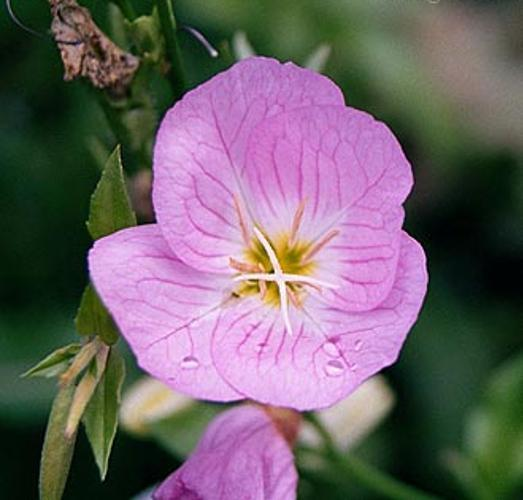

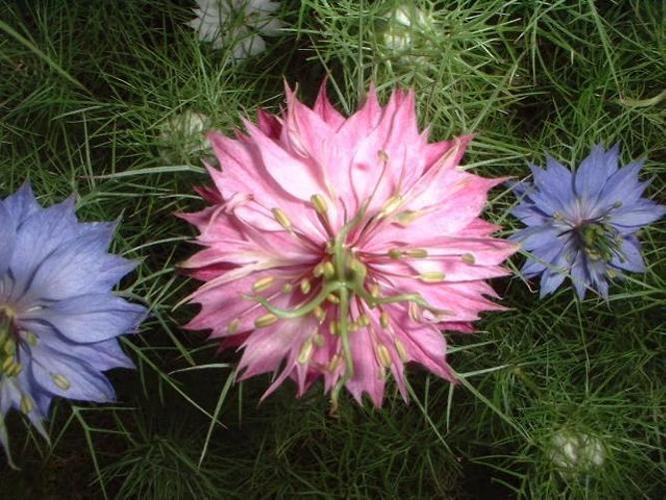

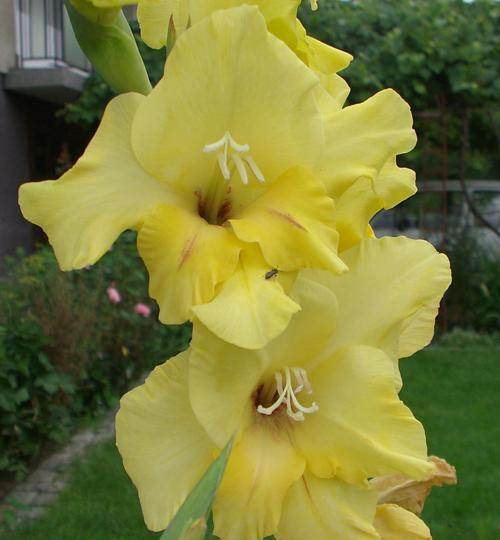

In [33]:
# preview images

from IPython.display import display, Image
display(Image(filename='/tmp/data/test/0/image_06734.jpg'))
display(Image(filename='/tmp/data/train/32/image_06443.jpg'))
display(Image(filename='/tmp/data/valid/42/image_02326.jpg'))

In [ ]:
# Transfer Learn

In [ ]:
# refs
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# 

In [35]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(226,226, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [36]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 226, 226, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 226, 226, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 226, 226, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [37]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               26214     
Total params: 21,163,686
Trainable params: 6,448,998
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #shear_range=0.2, # makes validation performance terrible, do we want this?
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train/',
        target_size=(226, 226),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/valid/',
        target_size=(226, 226),
        batch_size=20,
        class_mode='categorical')

Found 1020 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.


In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
 - 70s - loss: 4.6097 - acc: 0.0275 - val_loss: 4.4284 - val_acc: 0.0620
Epoch 2/10
 - 44s - loss: 4.3697 - acc: 0.0700 - val_loss: 4.2168 - val_acc: 0.1200
Epoch 3/10
 - 45s - loss: 4.1244 - acc: 0.1570 - val_loss: 3.9762 - val_acc: 0.1730
Epoch 4/10
 - 44s - loss: 3.8857 - acc: 0.2215 - val_loss: 3.7489 - val_acc: 0.2550
Epoch 5/10
 - 45s - loss: 3.6589 - acc: 0.2850 - val_loss: 3.5376 - val_acc: 0.3070
Epoch 6/10
 - 45s - loss: 3.4205 - acc: 0.3465 - val_loss: 3.3373 - val_acc: 0.3530
Epoch 7/10
 - 45s - loss: 3.2041 - acc: 0.4225 - val_loss: 3.1598 - val_acc: 0.3750
Epoch 8/10
 - 44s - loss: 3.0426 - acc: 0.4660 - val_loss: 3.0001 - val_acc: 0.4050
Epoch 9/10
 - 44s - loss: 2.8166 - acc: 0.5130 - val_loss: 2.8436 - val_acc: 0.4400
Epoch 10/10
 - 44s - loss: 2.6635 - acc: 0.5520 - val_loss: 2.7072 - val_acc: 0.4710


In [42]:
model.save('oxford-flowers-transfer-learn.h5')

In [43]:
# https://medium.com/@johnsondsouza23/export-keras-model-to-protobuf-for-tensorflow-serving-101ad6c65142
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Function to export Keras model to Protocol Buffer format
# Inputs:
#       path_to_h5: Path to Keras h5 model
#       export_path: Path to store Protocol Buffer model

def export_h5_to_pb(path_to_h5, export_path):

    # Set the learning phase to Test since the model is already trained.
    K.set_learning_phase(0)

    # Load the Keras model
    keras_model = load_model(path_to_h5)

    # Build the Protocol Buffer SavedModel at 'export_path'
    builder = saved_model_builder.SavedModelBuilder(export_path)

    # Create prediction signature to be used by TensorFlow Serving Predict API
    signature = predict_signature_def(inputs={"images": keras_model.input},
                                      outputs={"scores": keras_model.output})

    with K.get_session() as sess:
        # Save the meta graph and the variables
        builder.add_meta_graph_and_variables(sess=sess, tags=[tag_constants.SERVING],
                                         signature_def_map={"serving_default": signature})

    builder.save()

In [44]:
# version exported model
!rm -rf oxford-flowers-model/
export_h5_to_pb('oxford-flowers-transfer-learn.h5', 'oxford-flowers-model')
!ls oxford-flowers-model/
!mkdir oxford-flowers-model/oxford_flowers_vgg_transfer/
!mkdir oxford-flowers-model/oxford_flowers_vgg_transfer/00000001
!mv oxford-flowers-model/saved_model.pb oxford-flowers-model/oxford_flowers_vgg_transfer/00000001
!mv oxford-flowers-model/variables/ oxford-flowers-model/oxford_flowers_vgg_transfer/00000001

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: oxford-flowers-model/saved_model.pb
saved_model.pb	variables


In [45]:
!ls oxford-flowers-model/
!ls oxford-flowers-model/oxford_flowers_vgg_transfer/

oxford_flowers_vgg_transfer
00000001


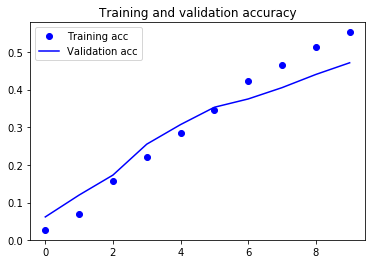

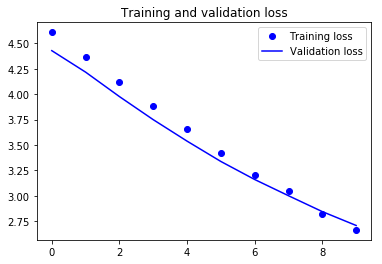

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()